### Import all the required libraries

In [1]:
import pandas as pd
import numpy as np
import random
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from collections.abc import Iterable
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
pd.options.mode.chained_assignment = None  # default='warn'

### Import and prepare the data

In [2]:
purchases = pd.read_csv('Desktop/Learning/CustomerSegmentation/Online_Retail_CSV.csv') #Change directory location to the folder with the data

In [3]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
# Change the data format for InvoiceDate to date. This will make the subsequent analysis easier.
purchases['InvoiceDate']=pd.to_datetime(purchases['InvoiceDate'])

In [5]:
# Remove transactions with null customer ID values
purchases = purchases.dropna(axis =0, subset =['CustomerID'])

In [6]:
print('Min:{}; Max:{}'.format(min(purchases.InvoiceDate),
                             max(purchases.InvoiceDate)))

Min:2010-01-12 08:26:00; Max:2011-12-10 17:19:00


In [7]:
# Check for duplicate entries and delete them
print('Duplicate entries: {}'.format(purchases.duplicated().sum()))
purchases.drop_duplicates(inplace = True)

Duplicate entries: 5225


In [8]:
# Check the number of customers, products and transactions in the dataset
pd.DataFrame([{'products': len(purchases['StockCode'].value_counts()),    
               'transactions': len(purchases['InvoiceNo'].value_counts()),
               'customers': len(purchases['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


In [9]:
# Group the data by customers and invoice number to get a sense of purchase behaviour
temp = purchases.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:20].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
12,12348.0,568172,3


In [10]:
# Certain invoice numbers have the letter 'C' in them. These might correspond to cancelled orders. Check number of transactions corresponding to cancelled orders
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346.0,541431,1,0
1,12346.0,C541433,1,1
2,12347.0,537626,31,0
3,12347.0,542237,29,0
4,12347.0,549222,24,0


Number of orders canceled: 3654/22190 (16.47%) 


In [11]:
display(purchases.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-02-08 08:48:00,4.25,12347.0,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347.0,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-07-12 14:57:00,1.25,12347.0,Iceland


In [12]:
# It appears that a cancelled transaction has a corresponding purchase with a positive quantity for the same customerID, description and unit price. Let's check if this is true.
df_check = purchases[purchases['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if purchases[(purchases['CustomerID'] == col[0]) & (purchases['Quantity'] == -col[1]) 
                & (purchases['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print('NOT TRUE')
        break

CustomerID      14527.0
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
NOT TRUE


In [13]:
# Our hypothesis above is not true since we found an entry for discount. Lets check again but this time discarding the discount entries
df_check = purchases[(purchases['Quantity'] < 0) & (purchases['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if purchases[(purchases['CustomerID'] == col[0]) & (purchases['Quantity'] == -col[1]) 
                & (purchases['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print('NOT TRUE')
        break

154 CustomerID                             15311.0
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
NOT TRUE


In [17]:
# It turns out that cancellations do not necessarily correspond to orders that would have been made beforehand. For the cancellations without counterparts, a few of them are probably due to the fact
# that few of these transactions were performed before December 2010 (the start of the entries in the dataset).

In [14]:
# Create a summary of cancelled orders and check for the existence of counterparts
purchases_cleaned = purchases.copy(deep = True)
purchases_cleaned['QuantityCancelled'] = 0

entry_to_remove = []; doubtful_entry = []

for index, col in purchases.iterrows():
    if(col['Quantity'] > 0) or col['Description'] == 'Discount' : continue
    df_test = purchases[(purchases['CustomerID'] == col['CustomerID']) &
                        (purchases['StockCode']  == col['StockCode']) &
                        (purchases['InvoiceDate'] < col['InvoiceDate']) &
                        (purchases['Quantity'] > 0)].copy()
                       
    #_________________________________
    # Cancellation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtful_entry.append(index)
    #________________________________
    # Cancellation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        purchases_cleaned.loc[index_order, 'QuantityCancelled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            purchases_cleaned.loc[ind, 'QuantityCancelled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break       

print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtful_entry: {}".format(len(doubtful_entry)))


entry_to_remove: 6197
doubtful_entry: 2558


In [15]:
# Drop the above entries and also check for other entries to be deleted
purchases_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
purchases_cleaned.drop(doubtful_entry, axis = 0, inplace = True)
remaining_entries = purchases_cleaned[(purchases_cleaned['Quantity'] < 0) & (purchases_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 40


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCancelled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358.0,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659.0,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-07-03 13:49:00,1.65,14048.0,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754.0,United Kingdom,0
197417,C553904,22897,OVEN MITT APPLES DESIGN,-11,2011-05-19 18:10:00,1.45,13081.0,United Kingdom,0


In [17]:
# Remove any remaining transactions with negative quantities
purchases_cleaned = purchases_cleaned[(purchases_cleaned['Quantity'] > 0)]
purchases_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392732 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   InvoiceNo          392732 non-null  object        
 1   StockCode          392732 non-null  object        
 2   Description        392732 non-null  object        
 3   Quantity           392732 non-null  int64         
 4   InvoiceDate        392732 non-null  datetime64[ns]
 5   UnitPrice          392732 non-null  float64       
 6   CustomerID         392732 non-null  float64       
 7   Country            392732 non-null  object        
 8   QuantityCancelled  392732 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.0+ MB


In [18]:
# Drop column - 'Quantity cancelled' 
del purchases_cleaned['QuantityCancelled']

In [19]:
# Get the invoice month from the invoice date
def get_month(x): return dt.datetime(x.year, x.month, 1)
purchases_cleaned['InvoiceMonth'] = purchases_cleaned['InvoiceDate'].apply(get_month)

In [20]:
purchases_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,2010-01-01
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,2010-01-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,2010-01-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,2010-01-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,2010-01-01


In [21]:
# Group by Invoice Month to view transactions by month
purchases_cleaned.groupby('InvoiceMonth').count()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
InvoiceMonth,,,,,,,,
2010-01-01,1898,1898,1898,1898,1898,1898,1898,1898
2010-02-01,1959,1959,1959,1959,1959,1959,1959,1959
2010-03-01,1086,1086,1086,1086,1086,1086,1086,1086
2010-05-01,2603,2603,2603,2603,2603,2603,2603,2603
2010-06-01,1897,1897,1897,1897,1897,1897,1897,1897
2010-07-01,1094,1094,1094,1094,1094,1094,1094,1094
2010-08-01,1909,1909,1909,1909,1909,1909,1909,1909
2010-09-01,1739,1739,1739,1739,1739,1739,1739,1739
2010-10-01,1358,1358,1358,1358,1358,1358,1358,1358


In [22]:
# The data for April and November 2010 is missing. Subsetting the data to include only 2011 data. 
purchases2 = purchases_cleaned.loc[purchases_cleaned['InvoiceMonth'].isin(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01', '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01', '2011-09-01', '2011-10-01', '2011-11-01', '2011-12-01'])]

In [23]:
# Check the number of products, transactions and customers in the 2011 data. Use this data for further analysis. 
pd.DataFrame([{'products': len(purchases2['StockCode'].value_counts()),    
               'transactions': len(purchases2['InvoiceNo'].value_counts()),
               'customers': len(purchases2['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3596,17136,4220


In [24]:
# Group transactions by month 
purchases2.groupby('InvoiceMonth').count()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
InvoiceMonth,,,,,,,,
2011-01-01,24873,24873,24873,24873,24873,24873,24873,24873
2011-02-01,22458,22458,22458,22458,22458,22458,22458,22458
2011-03-01,27107,27107,27107,27107,27107,27107,27107,27107
2011-04-01,26918,26918,26918,26918,26918,26918,26918,26918
2011-05-01,29553,29553,29553,29553,29553,29553,29553,29553
2011-06-01,32183,32183,32183,32183,32183,32183,32183,32183
2011-07-01,31950,31950,31950,31950,31950,31950,31950,31950
2011-08-01,29267,29267,29267,29267,29267,29267,29267,29267
2011-09-01,37524,37524,37524,37524,37524,37524,37524,37524


In [25]:
grouping = purchases2.groupby('CustomerID')['InvoiceMonth']

In [26]:
# Create a column for Cohort Month. This captures the month of the first transaction for a customer.
purchases2['CohortMonth'] = grouping.transform('min')
purchases2['CohortMonth']=pd.to_datetime(purchases2['CohortMonth'], format = '%Y-%m-%d')

In [27]:
# Define a function to get the year, month and day from a date
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [28]:
# Calculate the cohort index which calculates the number of months since the first transaction
invoice_year, invoice_month, invoice_day = get_date_int(purchases2, 'InvoiceMonth')
cohort_year, cohort_month, cohort_day = get_date_int(purchases2, 'CohortMonth')
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
purchases2['CohortIndex'] = years_diff * 12 + months_diff + 1

In [29]:
# Calculate the count of members in each cohort. This will be used for retention analysis.
grouping = purchases2.groupby(['CohortMonth','CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index = 'CohortMonth', columns = 'CohortIndex', values = 'CustomerID')

In [30]:
print(cohort_counts)

CohortIndex     1      2      3      4      5      6      7      8      9   \
CohortMonth                                                                  
2011-01-01   875.0  270.0  315.0  292.0  328.0  344.0  350.0  290.0  351.0   
2011-02-01   536.0  123.0  127.0  159.0  145.0  154.0  140.0  159.0  155.0   
2011-03-01   505.0   96.0  122.0  110.0  119.0  108.0  120.0  127.0  141.0   
2011-04-01   375.0   80.0   72.0   78.0   73.0   73.0   98.0   89.0   17.0   
2011-05-01   319.0   56.0   65.0   52.0   80.0   56.0   89.0   20.0    NaN   
2011-06-01   306.0   53.0   45.0   51.0   55.0   78.0   17.0    NaN    NaN   
2011-07-01   258.0   53.0   48.0   48.0   64.0    9.0    NaN    NaN    NaN   
2011-08-01   194.0   37.0   43.0   54.0   13.0    NaN    NaN    NaN    NaN   
2011-09-01   270.0   39.0   54.0    4.0    NaN    NaN    NaN    NaN    NaN   
2011-10-01   289.0   58.0    9.0    NaN    NaN    NaN    NaN    NaN    NaN   
2011-11-01   259.0   11.0    NaN    NaN    NaN    NaN    NaN    

In [31]:
# Store the first column as cohort sizes
cohort_sizes = cohort_counts.iloc[:,0]

# Divide all values in the cohort_counts table by cohort_sizes
retention = cohort_counts.divide(cohort_sizes, axis = 0)

# Review the retention table
retention.round(3)*100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,
2011-01-01,100.0,30.9,36.0,33.4,37.5,39.3,40.0,33.1,40.1,38.9,46.3,17.1
2011-02-01,100.0,22.9,23.7,29.7,27.1,28.7,26.1,29.7,28.9,35.1,10.3,NaN
2011-03-01,100.0,19.0,24.2,21.8,23.6,21.4,23.8,25.1,27.9,6.9,NaN,NaN
2011-04-01,100.0,21.3,19.2,20.8,19.5,19.5,26.1,23.7,4.5,NaN,NaN,NaN
2011-05-01,100.0,17.6,20.4,16.3,25.1,17.6,27.9,6.3,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.3,14.7,16.7,18.0,25.5,5.6,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,20.5,18.6,18.6,24.8,3.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,19.1,22.2,27.8,6.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-01,100.0,14.4,20.0,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Create a better visual for the retention table
class AxTransformer:
    def __init__(self, datetime_vals=False):
        self.datetime_vals = datetime_vals
        self.lr = linear_model.LinearRegression()
        
        return
    
    def process_tick_vals(self, tick_vals):
        if not isinstance(tick_vals, Iterable) or isinstance(tick_vals, str):
            tick_vals = [tick_vals]
            
        if self.datetime_vals == True:
            tick_vals = pd.to_datetime(tick_vals).astype(int).values
            
        tick_vals = np.array(tick_vals)
            
        return tick_vals
    
    def fit(self, ax, axis='x'):
        axis = getattr(ax, f'get_{axis}axis')()
        
        tick_locs = axis.get_ticklocs()
        tick_vals = self.process_tick_vals([label._text for label in axis.get_ticklabels()])
        
        self.lr.fit(tick_vals.reshape(-1, 1), tick_locs)
        
        return
    
    def transform(self, tick_vals):        
        tick_vals = self.process_tick_vals(tick_vals)
        tick_locs = self.lr.predict(np.array(tick_vals).reshape(-1, 1))
        
        return tick_locs
    
def set_date_ticks(ax, start_date, end_date, axis='y', date_format='%Y-%m-%d', **date_range_kwargs):
    dt_rng = pd.date_range(start_date, end_date, **date_range_kwargs)

    ax_transformer = AxTransformer(datetime_vals=True)
    ax_transformer.fit(ax, axis=axis)
    
    getattr(ax, f'set_{axis}ticks')(ax_transformer.transform(dt_rng))
    getattr(ax, f'set_{axis}ticklabels')(dt_rng.strftime(date_format))

    ax.tick_params(axis=axis, which='both', bottom=True, top=False, labelbottom=True)
    
    return ax

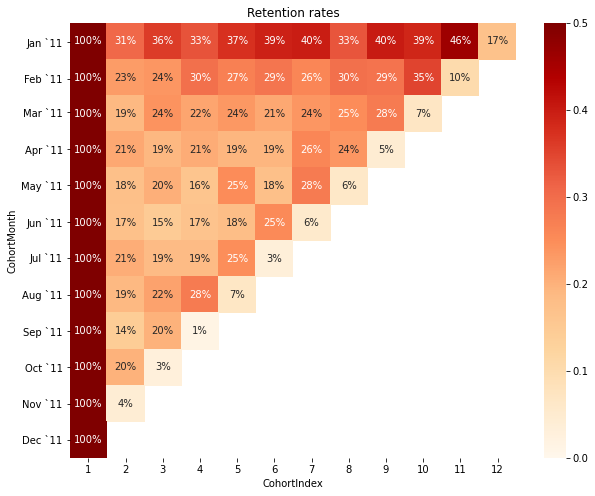

In [33]:
plt.figure(figsize = (10, 8))
plt.title('Retention rates')
ax = sns.heatmap(data = retention,
            annot = True,
            fmt = '.0%',
            vmin = 0.0,
            vmax = 0.5,
            cmap = 'OrRd')
set_date_ticks(ax, '2011-01-01', '2011-12-01', freq ='1MS', date_format = '%b `%y')
plt.show()

In [34]:
# Instead of calculating the retention rate, we can also calculate the average quantity bought by each cohort
grouping2 = purchases2.groupby(['CohortMonth','CohortIndex'])
cohort_data2 = grouping2['Quantity'].mean()
cohort_data2 = cohort_data2.reset_index()
average_quantity = cohort_data2.pivot(index='CohortMonth',
                                       columns = 'CohortIndex',
                                       values = 'Quantity')
average_quantity.round(1)

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,
2011-01-01,15.3,14.6,16.3,15.6,15.4,14.9,16.2,13.9,16.6,14.9,13.3,15.1
2011-02-01,11.6,19.2,17.4,18.7,17.3,18.9,13.3,15.8,10.8,12.0,12.6,NaN
2011-03-01,9.5,11.8,11.1,9.0,10.6,11.7,10.9,12.2,10.3,11.8,NaN,NaN
2011-04-01,10.7,11.7,10.5,7.8,8.4,10.4,9.3,11.5,17.6,NaN,NaN,NaN
2011-05-01,10.1,8.8,12.5,11.3,44.3,11.5,9.3,12.3,NaN,NaN,NaN,NaN
2011-06-01,9.1,8.8,9.6,10.7,10.2,9.8,10.4,NaN,NaN,NaN,NaN,NaN
2011-07-01,10.6,10.5,9.0,8.2,6.4,7.7,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,11.5,8.1,9.0,9.2,10.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-01,13.5,11.0,10.0,9.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculate RFM Metrics

In [36]:
# Create a Total sum column
purchases2['TotalSum'] = purchases2['Quantity'] * purchases2['UnitPrice']

In [37]:
# Create a hypothetical snapshot day as if we're doing the analysis recently
snapshot_date = max(purchases2.InvoiceDate) + dt.timedelta(days=1)

In [38]:
purchases2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex,TotalSum
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-04-01 10:00:00,1.95,13313.0,United Kingdom,2011-04-01,2011-04-01,1,19.5
42482,539993,21499,BLUE POLKADOT WRAP,25,2011-04-01 10:00:00,0.42,13313.0,United Kingdom,2011-04-01,2011-04-01,1,10.5
42483,539993,21498,RED RETROSPOT WRAP,25,2011-04-01 10:00:00,0.42,13313.0,United Kingdom,2011-04-01,2011-04-01,1,10.5
42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-04-01 10:00:00,2.10,13313.0,United Kingdom,2011-04-01,2011-04-01,1,10.5
42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-04-01 10:00:00,1.25,13313.0,United Kingdom,2011-04-01,2011-04-01,1,12.5


In [39]:
# Aggregate data on a customer level
datamart = purchases2.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum':'sum'})

# Rename columns for easier interpretation
datamart.rename(columns = {'InvoiceDate': 'Recency',
                           'InvoiceNo':'Frequency',
                           'TotalSum': 'MonetaryValue'}, inplace = True)

#Check the first few rows
datamart.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,327,1,77183.60
12347.0,41,151,3598.21
12348.0,77,14,904.44
12349.0,20,73,1757.55
12350.0,312,17,334.40


In [40]:
# Assign RFM quartiles
# Recency
r_labels = range(4, 0, -1)
r_quartiles = pd.qcut(datamart['Recency'], 4, labels = r_labels)
datamart = datamart.assign(R = r_quartiles.values)

# Frequency
f_labels = range(1,5)
f_quartiles = pd.qcut(datamart['Frequency'], 4, labels = f_labels)
datamart = datamart.assign(F = f_quartiles.values)

# Monetary Value
m_labels = range(1,5)
m_quartiles = pd.qcut(datamart['MonetaryValue'], 4, labels = m_labels)
datamart = datamart.assign(M = m_quartiles.values)

In [44]:
# Create RFM Segment & RFM Score
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
datamart['RFM_Segment'] = datamart.apply(join_rfm, axis = 1)
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)

In [45]:
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,327,1,77183.60,1,1,4,114,6
12347.0,41,151,3598.21,3,4,4,344,11
12348.0,77,14,904.44,2,1,3,213,6
12349.0,20,73,1757.55,4,3,4,434,11
12350.0,312,17,334.40,1,1,2,112,4


In [46]:
# Largest RFM Segments
datamart.groupby('RFM_Segment').size().sort_values(ascending=False)[:10]

RFM_Segment
444    395
111    350
344    229
122    202
211    175
233    164
433    162
222    161
333    144
311    126
dtype: int64

In [47]:
# Summary metrics per RFM score
datamart.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean','count']
}).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           240.9       8.0         150.7   350
4           172.9      14.0         227.6   368
5           154.9      20.7         359.4   521
6           103.1      26.6         629.8   479
7            94.5      39.0        1258.4   411
8            65.4      53.0        1034.1   461
9            55.8      78.6        1453.8   395
10           39.8     118.3        1934.5   431
11           25.5     176.1        4366.3   409
12           11.2     357.1        8869.8   395

In [48]:
# Key k-means assumptions
#1. Symmetric distribution of variables
#2. Variables with same average values
#3. Variables with same variance

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Recency', ylabel='Density'>

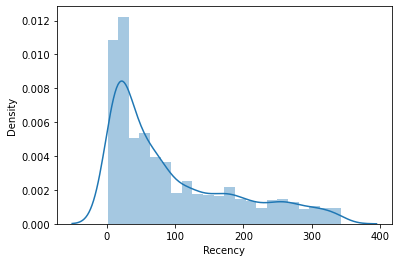

In [50]:
# Data preprocessing for k-means. Check if the distributions for recency, frequency, and monetary value are symmetric
sns.distplot(datamart['Recency'])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Frequency', ylabel='Density'>

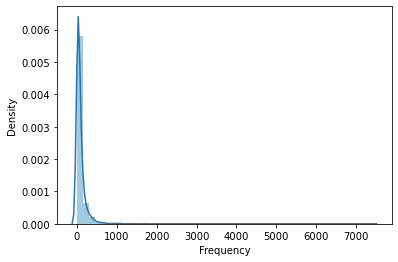

In [51]:
sns.distplot(datamart['Frequency'])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='MonetaryValue', ylabel='Density'>

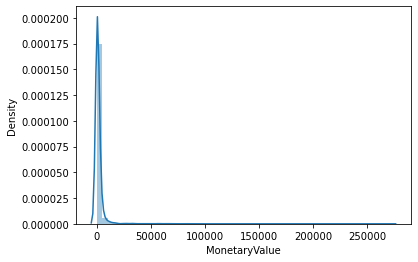

In [52]:
sns.distplot(datamart['MonetaryValue'])

In [53]:
# The plots are not symmetric. We will centre and scale the data before doing k-means segmentation.
# Create a copy of the earlier datamart dataset to do k-means clustering 
datamart_rfm = datamart

In [54]:
# Remove the unwanted columns
datamart.head()
datamart_rfm.drop(['R', 'F', 'M', 'RFM_Segment', 'RFM_Score'], axis=1, inplace=True)

In [55]:
datamart_rfm.describe()

,Recency,Frequency,MonetaryValue
count,4220.000000,4220.000000,4220.000000
mean,95.036493,86.980806,1970.802409
std,91.532581,216.375114,8665.793178
min,1.000000,1.000000,0.000000
25%,23.000000,17.000000,302.577500
50%,59.000000,40.000000,657.550000
75%,152.000000,95.000000,1610.510000
max,343.000000,7390.000000,271614.140000


In [56]:
# To remove the skewness, we will apply log transformation. This means that the values can't be negative or zero. So converting monetary values that are zero to one.
datamart_rfm.loc[datamart_rfm.MonetaryValue == 0, 'MonetaryValue'] = 1

In [57]:
datamart_rfm.describe()

,Recency,Frequency,MonetaryValue
count,4220.000000,4220.000000,4220.000000
mean,95.036493,86.980806,1970.802645
std,91.532581,216.375114,8665.793125
min,1.000000,1.000000,1.000000
25%,23.000000,17.000000,302.577500
50%,59.000000,40.000000,657.550000
75%,152.000000,95.000000,1610.510000
max,343.000000,7390.000000,271614.140000


In [58]:
# Preprocessing for k-means. Apply log transformation before using standard scaler.
datamart_log = np.log(datamart_rfm)
scaler = StandardScaler()
scaler.fit(datamart_log)

datamart_normalised = scaler.transform(datamart_log)
print('mean: ', datamart_normalised.mean(axis=0).round(2))
print('std: ', datamart_normalised.std(axis=0).round(2))

mean:  [-0.  0. -0.]
std:  [1. 1. 1.]


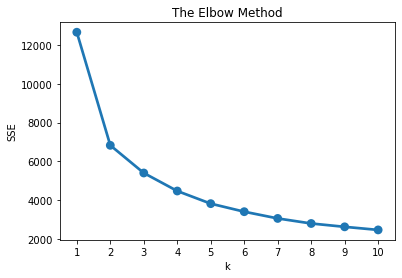

In [59]:
# The data meets the three requirements for k-means clustering 
# Choosing the number of clusters
# Use elbow criterion method - plot the number of clusters against within-cluster sum-of-squared-errors (SSE)- sum of squared distances from every data point to their cluster center
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, random_state = 1)
    kmeans.fit(datamart_normalised)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

# plot sse for each k
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y = list(sse.values()))
plt.show()

In [60]:
# Run kmeans segmentation using both 2 and 3 clusters
kmeans2 = KMeans(n_clusters = 2, random_state = 1)
kmeans3 = KMeans(n_clusters = 3, random_state = 1)
kmeans2.fit(datamart_normalised)
kmeans3.fit(datamart_normalised)
cluster_labels2 = kmeans2.labels_
cluster_labels3 = kmeans3.labels_

datamart_rfm_k2 = datamart_rfm.assign(Cluster = cluster_labels2)
datamart_rfm_k3 = datamart_rfm.assign(Cluster = cluster_labels3)

In [61]:
# Summary statistics for clusters (k = 2)
datamart_rfm_k2.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         142.0      24.0         456.0  2324
1          37.0     164.0        3828.0  1896

In [62]:
# Summary statistics for clusters (k = 3)
datamart_rfm_k3.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          83.0      64.0        1119.0  1712
1         161.0      15.0         284.0  1495
2          19.0     233.0        5899.0  1013

In [63]:
# Create a snake plot for visualising the difference in R,F,M values between different clusters
datamart_normalised = pd.DataFrame(datamart_normalised,
                                  index = datamart_rfm.index,
                                  columns = datamart_rfm.columns)
datamart_normalised['Cluster'] = datamart_rfm_k3['Cluster']
datamart_melt = pd.melt(datamart_normalised.reset_index(),
                       id_vars=['CustomerID', 'Cluster'],
                       value_vars = ['Recency', 'Frequency', 'MonetaryValue'],
                       var_name = 'Attribute' ,
                       value_name = 'Value'
                       )

<AxesSubplot:title={'center':'Snake plot of Recency, Frequency and Monetary Value'}, xlabel='Attribute', ylabel='Value'>

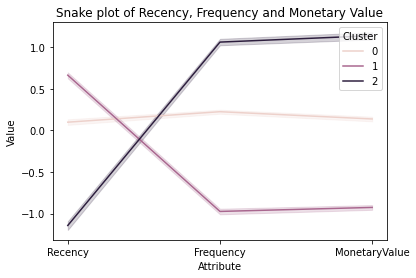

In [64]:
# Visualise the snake plot
plt.title('Snake plot of Recency, Frequency and Monetary Value')
sns.lineplot(x = "Attribute", y = "Value", hue = "Cluster", data = datamart_melt)